In [2]:
import sklearn
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("dataset-of-00s.csv")
df = df.drop(['uri', 'track', 'artist'], axis = 1)

In [4]:
df.shape

(5872, 16)

In [5]:
df.isna().any()

danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_ms         False
time_signature      False
chorus_hit          False
sections            False
target              False
dtype: bool

In [6]:
df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
dtype: object

In [7]:
df['target'].value_counts()

1    2936
0    2936
Name: target, dtype: int64

In [8]:
df.head(15)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,1
1,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,1
2,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0
3,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0
4,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,1
5,0.726,0.837,11,-7.223,0,0.0965,0.373000,0.268000,0.1360,0.969,135.347,192720,4,28.29051,10,0
6,0.365,0.922,1,-2.644,1,0.0710,0.002850,0.000000,0.3210,0.290,77.250,89427,4,45.77202,4,0
7,0.726,0.631,11,-8.136,0,0.0334,0.220000,0.000000,0.1930,0.746,124.711,239240,4,35.59732,10,1
8,0.481,0.786,10,-5.654,1,0.0288,0.053800,0.000000,0.0759,0.389,153.105,253640,4,19.65701,11,1
9,0.647,0.324,7,-9.679,1,0.0377,0.354000,0.000000,0.1150,0.344,124.213,314286,3,32.66343,16,0


## Observations: This is a pretty good dataset. There are no missing values. And the target variable is balanced. This is going to make our job much easier! 

## Exploratory Data Analysis (EDA)

<AxesSubplot:>

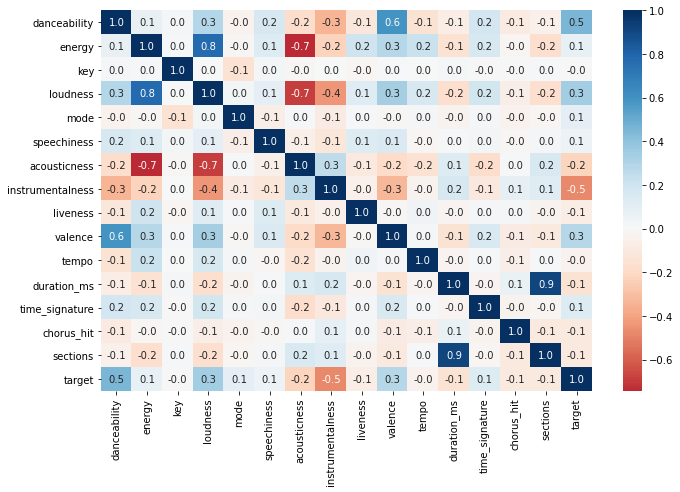

In [9]:
corr = df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(corr, annot = True, fmt = ".1f", cmap = 'RdBu', center = 0, ax = ax)

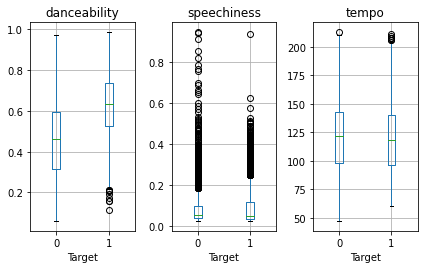

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3)
df.boxplot(column = 'danceability', by = 'target', ax = axes[0])
df.boxplot(column = 'speechiness', by = 'target', ax = axes[1])
df.boxplot(column = 'tempo', by = 'target', ax = axes[2])


for ax in axes:
    ax.set_xlabel('Target')
    
plt.suptitle('')
plt.tight_layout()

<AxesSubplot:xlabel='target', ylabel='energy'>

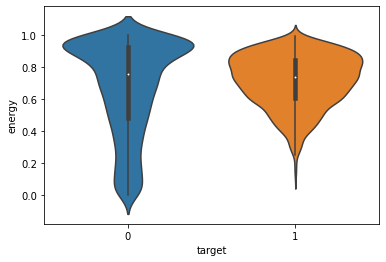

In [15]:
sns.violinplot(x = 'target', y = 'energy', data = df)

## Split Data

In [12]:
X = df.drop('target', axis = 1)
y = df['target']

In [13]:
X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size = 0.3, random_state = 123)

## Model Building

In [14]:
parameters = {
        'max_depth': range(2, 6),
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'colsample_bynode': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'gamma': [0, 5, 10, 15, 20],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'lambda': [0.1, 0.25, 0.5, 0.75, 1]
}

start = time.time() 

clf = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = "logloss"), 
                         parameters, n_jobs=4, scoring = "roc_auc", n_iter = 300,
                         random_state = 123)

clf.fit(X_train, y_train)

end = time.time()

# print the number of seconds it takes to run the hyperparameter search
print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  956.3309078216553


In [15]:
train_pred = clf.predict(X_train)
val_pred = clf.predict(X_valid)

## Feature Importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance score', ylabel='Features'>

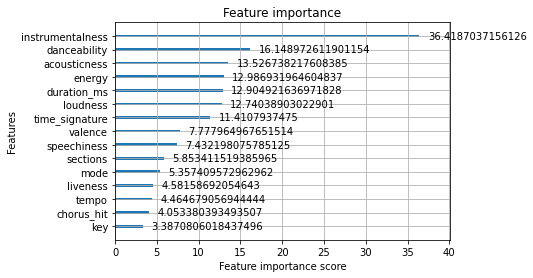

In [16]:
# non-normalized feature importance
# XGBoost has a built-in function to plot importance
xgb.plot_importance(clf.best_estimator_, importance_type = "gain", xlabel = "Feature importance score")

## Model Results 

In [17]:
print("Training recall: ", metrics.recall_score(y_train, train_pred))
print("Validation recall: ", metrics.recall_score(y_valid, val_pred))

print("\n")

print("Training precision: ", metrics.precision_score(y_train, train_pred))
print("Validation precision: ", metrics.precision_score(y_valid, val_pred))

print("\n")

print("Training accuracy: ", metrics.accuracy_score(y_train, train_pred))
print("Validation accuracy: ", metrics.accuracy_score(y_valid, val_pred))

print("\n")

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_valid)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
print("Training AUC: ", metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_val_prob[:,1], pos_label = 1)
print("Validation AUC: ", metrics.auc(fpr, tpr))

Training recall:  0.9381746810598626
Validation recall:  0.8964365256124721


Training precision:  0.8917910447761194
Validation precision:  0.8385416666666666


Training accuracy:  0.9128953771289537
Validation accuracy:  0.8592508513053349


Training AUC:  0.9745385456253953
Validation AUC:  0.9307566196486018
